# Example Usage

Results are still preliminary. This gives a toy example for how to use the code in this repository for model training, inference, and result visualization. Performance is not yet optimized and there are still more validation tests to finish.

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import numpy as np
import torch
import torch.nn.functional as F
from max_deeplab.model import MaXDeepLabS
from max_deeplab.losses import MaXDeepLabLoss
from datasets.coco_panoptic import build
from torch.optim import Adam
from util.misc import collate_fn
from torch.utils.data import DataLoader
from util.visualize import display_instances, roll_image

from einops import rearrange
from matplotlib import pyplot as plt

In [6]:
config = {}
HW = 224
N = 30 #if the loaded image has more than 30 masks, this number must be increased
bsz = 2 #small batch for a toy example; too small for actual model training

config['image_size'] = (HW, HW)
config['coco_path'] = 'coco_panoptic/' #directory with image and annotation data
data = build('train', config)

#dictionary of class names from Coco Panoptic
category_dict = {dct['id']: dct['name'] for dct in data.coco['categories']}
category_dict[201] = 'no_class'

#create a dataloader that collates batch with padding
#see utils.misc.collate_fn
padding_dict = {'image': 0, 'masks': 0, 'semantic_mask': 0, 'labels': 0, 'image_id': 0} #padding values
sizes_dict = {'image': None, 'masks': N, 'semantic_mask': None, 'labels': N, 'image_id': None} #padded sizes
collate_lambda = lambda b: collate_fn(b, padding_dict, sizes_dict)

loader = DataLoader(data, batch_size=bsz, shuffle=True, collate_fn=collate_lambda)

#we will just try to overfit a single batch of images
batch = iter(loader).next()

In [7]:
device = torch.device('cuda:0')
P = batch['image'].to(device)

masks = batch['masks'].to(device)
labels = batch['labels'].to(device)
semantic = batch['semantic_mask'].to(device)
target_tuple = (masks, labels, semantic)

In [8]:
model = MaXDeepLabS(im_size=HW, n_classes=202, n_masks=N).cuda()
criterion = MaXDeepLabLoss().cuda()
optimizer = Adam(model.parameters(), lr=5e-4) #RAdam later, just Adam for testing

In [9]:
for i in range(1800):
    optimizer.zero_grad()

    out = model(P)
    loss, loss_items = criterion(out, target_tuple)
    loss.backward()
    optimizer.step()

    if (i + 1) % 50 == 0:
        loss_string = ', '.join([f'{k}: {v}' for k,v in loss_items.items()])
        print(f'epoch {i + 1}: ', loss.item())
        print(loss_string)

epoch 50:  2.116008996963501
pq: 0.34005048871040344, semantic: 0.6166760921478271, maskid: 1.5946742296218872, instdisc: 0.0007791762473061681
epoch 100:  1.5727076530456543
pq: 0.3021034002304077, semantic: 0.24778252840042114, maskid: 1.3939456939697266, instdisc: 0.0004311460943426937
epoch 150:  1.460829734802246
pq: 0.3107879161834717, semantic: 0.13898548483848572, maskid: 1.2957693338394165, instdisc: 0.0007495349273085594
epoch 200:  1.384331226348877
pq: 0.3037169873714447, semantic: 0.10457591712474823, maskid: 1.2270853519439697, instdisc: 0.00047868717228993773
epoch 250:  1.304750680923462
pq: 0.2951712906360626, semantic: 0.0778324082493782, maskid: 1.1362324953079224, instdisc: 0.0005346256657503545
epoch 300:  1.259326457977295
pq: 0.28986144065856934, semantic: 0.0670836791396141, maskid: 1.0739821195602417, instdisc: 0.00046379907871596515
epoch 350:  1.2222799062728882
pq: 0.28528517484664917, semantic: 0.060830846428871155, maskid: 1.017411231994629, instdisc: 0.00

In [10]:
#basic inference
with torch.no_grad():
    out = model(P)

    instance_probs = F.softmax(out[0], dim=1)
    instances = instance_probs.argmax(dim=1)
    instances = F.one_hot(instances, num_classes=N).permute(0, 3, 1, 2)
    
    #filter out pixels by mask id confidence
    #instances[instance_probs < 0.4] = 0
    
    class_confidence, classes = F.softmax(out[1], dim=-1).max(-1)

    semantic = F.softmax(out[2], dim=1).argmax(dim=1)

    #throughout padding instances in gt
    keep_gt_instances = torch.where(batch['labels'].tensors > 0)
    
    #filter out low confidence instances from predictions
    keep_pred_instances = torch.where(torch.logical_and(classes > 0, class_confidence > 0.7))

In [11]:
gt_instances = []
gt_classes = []
gt_class_names = []

pred_instances = []
pred_classes = []
pred_class_names = []

for index in range(bsz):
    keep_gt = keep_gt_instances[1][keep_gt_instances[0] == index]
    keep_pred = keep_pred_instances[1][keep_pred_instances[0] == index]
    
    gt_instances.append(batch['masks'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_classes.append(batch['labels'].tensors.detach()[index, keep_gt].cpu().numpy())
    gt_class_names.append([category_dict[l] for l in gt_classes[-1]])

    pred_instances.append(instances.detach()[index, keep_pred].cpu().numpy())
    pred_classes.append(classes.detach()[index, keep_pred].cpu().numpy())
    pred_class_names.append([category_dict[l] for l in pred_classes[-1]])

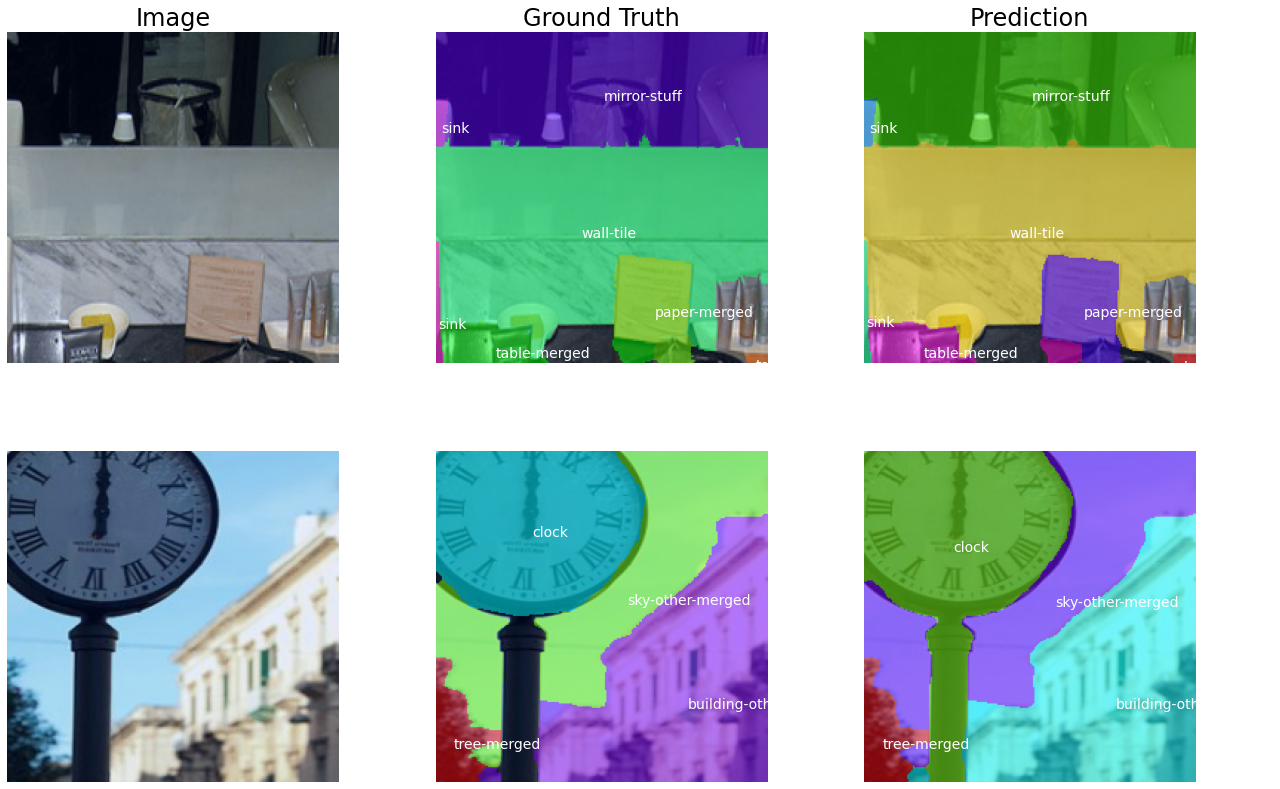

In [12]:
f, ax = plt.subplots(bsz, 3, figsize=(18, 6*bsz), squeeze=False)

for index in range(bsz):
    display_image = roll_image(batch['image'].tensors.detach().cpu().numpy()[index])
    ax[index, 0].imshow(display_image)
    ax[index, 0].axis('off')
    display_instances(display_image, gt_instances[index], gt_class_names[index], ax=ax[index, 1])
    display_instances(display_image, pred_instances[index], pred_class_names[index], ax=ax[index, 2])
    
ax[0, 0].set_title('Image', fontsize=24)
ax[0, 1].set_title('Ground Truth', fontsize=24)
ax[0, 2].set_title('Prediction', fontsize=24)
plt.tight_layout()